In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import math
import anyterrain as at
from gurobipy import *
np.set_printoptions(linewidth=np.inf)

### Create a world consisting of multiple planes. 

The result is a 2-D matrix *terrain*. Each line of the matrix represent a plane 

$$ax+by+cz+d=0$$

A line of the *terrain* matrix is 

$$[a, b, c, d, x_{max}, x_{min}, y_{max}, y_{min}, \sigma]$$

where $\sigma$ is the covariance of the plane

/Users/LiShuo/anymal_planning/anyterrain.py:69: RuntimeWarning: invalid value encountered in true_divide
  Z = ((-coefficients[plane,0]*X-coefficients[plane,1]*Y)-coefficients[plane,3])/coefficients[plane,2]
/Users/LiShuo/anymal_planning/anyterrain.py:70: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X, Y, Z,color = [0.3,0.3,0.3])


The 3rd line of terrain is 
[ 0.          0.          1.         -0.4         1.          3.          5.33333333  5.66666667  1.        ]


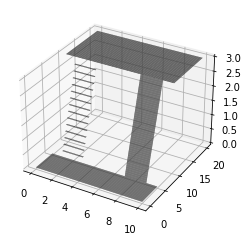

In [2]:
fig = plt.figure(1)
ax = fig.gca(projection='3d')
terrain = at.Terrain(ax,0)
solutions = {}
planesCoef = terrain.terrainPlanes
planes = np.array(range(planesCoef.shape[0]))
print("The 3rd line of {} is {}{}".format('terrain',"\n", planesCoef[3,:]))

### Prepare decision variables for Gurobi
we set 50 steps towards the goal and create a Gurobi object

In [3]:
N = 50
model = Model('FootStep Planning')

Using license file /Users/LiShuo/gurobi.lic
Academic license - for non-commercial use only


We create decision variables 

footstepStates[10,'RF','x']: the **x** position of the **right-front** foot at step **10**

footstepAssignment[10,'RF',6] == True: the **right-front** foothold at step **10** belongs to plane **6**

footstepStrength[10,'RF'] == 0: the **right-front** foot at step **10** only touches the foodhold 'slightly'/once 

footstepStrength[10,'RF'] == 1: the **right-front** foot at step **10** touches the foodhold with maximum times.

Here we use continuous variables instead of intergers to represent touching times to decrease the complexity of the MIP

In [4]:
steps = [i for i in range(N)]
footIds = ['LF','RF','LH','RH']
states = ["x","y","z","theta"]


footstepStates = model.addVars(steps,footIds,states,name="footstepStates")

footstepAssignment = model.addVars(steps,footIds,planes,name="footstepAssignment",vtype=GRB.BINARY)

footstepStrength = model.addVars(steps,footIds,name = "footstepStrength")


### Add constraints to Gurobi
Assign each foothold on **only** one plane.

In [5]:
constOnePlane = model.addConstrs((quicksum(footstepAssignment[step,footId,plane] for plane in planes) == 1 for step in steps for footId in footIds),name='constOnePlane')

Once a foothold 
$$\mathbf{f}_i=[x_i,y_i,z_i]^{\rm T}$$ 
is assigned on plane $r$, its 3-D position should be constrained on that plane and within the limit
$$a_r x_i+b_r y_i+c_r z_i+d_r=0$$
$$x^r_{min} < x_i < x^r_{max}$$
$$y^r_{min} < y_i < y^r_{max}$$

In [6]:
constOnThePlane0 = model.addConstrs(( (footstepAssignment[step,footId,plane]==1) >>(planesCoef[plane,0]*footstepStates[step,footId,'x']+planesCoef[plane,1]*footstepStates[step,footId,'y']+planesCoef[plane,2]*footstepStates[step,footId,'z']+planesCoef[plane,3] == 0) 
                                     for step in steps for footId in footIds for plane in planes ) ,name='constOnThePlane')
constOnThePlane1 = model.addConstrs((footstepAssignment[step,footId,plane]==1) >> (footstepStates[step,footId,"x"] <= planesCoef[plane,5]) for step in steps for footId in footIds for plane in planes)
constOnThePlane2 = model.addConstrs((footstepAssignment[step,footId,plane]==1) >> (footstepStates[step,footId,"x"] >= planesCoef[plane,4]) for step in steps for footId in footIds for plane in planes)
constOnThePlane3 = model.addConstrs((footstepAssignment[step,footId,plane]==1) >> (footstepStates[step,footId,"y"] <= planesCoef[plane,7]) for step in steps for footId in footIds for plane in planes)
constOnThePlane4 = model.addConstrs((footstepAssignment[step,footId,plane]==1) >> (footstepStates[step,footId,"y"] >= planesCoef[plane,6]) for step in steps for footId in footIds for plane in planes)

Limit the distance between each step for each leg (only limit $x$ and $y$)
$$||\mathbf{f}_{i,j}-\mathbf{f}_{i-1,j}||_2 < \alpha_1$$

In [7]:
maxDistanceBetweenSteps = 0.4
const5 = model.addConstrs((footstepStates[step,footId,state]-footstepStates[step-1,footId,state] <= maxDistanceBetweenSteps for step in steps for footId in footIds for state in states if step !=steps[0]),name="stepLimit")
const6 = model.addConstrs((footstepStates[step,footId,state]-footstepStates[step-1,footId,state] >= -maxDistanceBetweenSteps for step in steps for footId in footIds for state in states if step !=steps[0]),name="stepLimit")

Constrain the geometry between four legs at each step. 
For example, the RF leg should not to the left of the LF leg, etc.

In [8]:

minDistanceBetweenLeftAndRight = 0.2
maxDistanceBetweenLeftAndRight = 0.4
minDistanceBetweenFrontAndHind= 0.3
maxDistanceBetweenFrontAndHind= 0.8
const5 = model.addConstrs((footstepStates[step,footIds[1],"x"] - footstepStates[step,footIds[0],"x"] >= minDistanceBetweenLeftAndRight for step in steps), name = "RF limit")
const6 = model.addConstrs((footstepStates[step,footIds[1],"x"] - footstepStates[step,footIds[0],"x"] <=  maxDistanceBetweenLeftAndRight for step in steps), name = "RF limit")
const7 = model.addConstrs((footstepStates[step,footIds[1],"y"] - footstepStates[step,footIds[0],"y"] >= -maxDistanceBetweenLeftAndRight for step in steps), name = "RF limit")
const8 = model.addConstrs((footstepStates[step,footIds[1],"y"] - footstepStates[step,footIds[0],"y"] <=  maxDistanceBetweenLeftAndRight for step in steps), name = "RF limit")

const9 = model.addConstrs((footstepStates[step,footIds[2],"x"] - footstepStates[step,footIds[0],"x"] <=  maxDistanceBetweenLeftAndRight for step in steps), name = "LH limit")
const10 = model.addConstrs((footstepStates[step,footIds[2],"x"] - footstepStates[step,footIds[0],"x"] >=  -maxDistanceBetweenLeftAndRight for step in steps), name = "LH limit")
const11 = model.addConstrs((footstepStates[step,footIds[0],"y"] - footstepStates[step,footIds[2],"y"] <=  maxDistanceBetweenFrontAndHind for step in steps), name = "LH limit")
const12 = model.addConstrs((footstepStates[step,footIds[0],"y"] - footstepStates[step,footIds[2],"y"] >=  minDistanceBetweenFrontAndHind for step in steps), name = "LH limit")


const13 = model.addConstrs((footstepStates[step,footIds[3],"x"] - footstepStates[step,footIds[1],"x"] <=  maxDistanceBetweenLeftAndRight for step in steps), name = "RH limit")
const14 = model.addConstrs((footstepStates[step,footIds[3],"x"] - footstepStates[step,footIds[1],"x"] >=  -maxDistanceBetweenLeftAndRight for step in steps), name = "RH limit")
const15 = model.addConstrs((footstepStates[step,footIds[1],"y"] - footstepStates[step,footIds[3],"y"] <=  maxDistanceBetweenFrontAndHind for step in steps), name = "RH limit")
const16 = model.addConstrs((footstepStates[step,footIds[1],"y"] - footstepStates[step,footIds[3],"y"] >=  minDistanceBetweenFrontAndHind for step in steps), name = "RH limit")

Limit touching strength. Here we force $footstepStrength==0$ which indicates the feet only touch footholds **once**

In [9]:
#model.addConstrs((footstepStrength[step,footId] <=  1.0 for step in steps for footId in footIds))
const17 = model.addConstrs((footstepStrength[step,footId] ==  0.0 for step in steps for footId in footIds))

Constraints on initial states and final states

In [10]:
initialPoint = [0.0,0.0]
targetPoint = [2.0,18.0]
const17 = model.addConstrs(footstepStates[steps[0],footId,state] <= maxDistanceBetweenSteps for state in states for footId in footIds if state == states[0] or state == states[1])
const17 = model.addConstrs(footstepStates[steps[-1],footId,states[0]]-targetPoint[0] <= maxDistanceBetweenSteps for footId in footIds)
const17 = model.addConstrs(footstepStates[steps[-1],footId,states[0]]-targetPoint[0] >= -maxDistanceBetweenSteps for footId in footIds)
const17 = model.addConstrs(footstepStates[steps[-1],footId,states[1]]-targetPoint[1] <= maxDistanceBetweenSteps for footId in footIds)
const17 = model.addConstrs(footstepStates[steps[-1],footId,states[1]]-targetPoint[1] >= -maxDistanceBetweenSteps for footId in footIds)
const17 = model.addConstrs(footstepStates[steps[0],footId,states[3]] == 0.0 for footId in footIds)
const17 = model.addConstrs(footstepStates[steps[-1],footId,states[3]] == 0.0 for footId in footIds)

### Set Gurobi target and slove the problem

$$\min_{\mathbf{H},\mathbf{f}_{i,j},\Gamma} P\sum_{i,j}||\mathbf{f}_{i+1,j}-\mathbf{f}_{i,j}|| 
    +Q\sum_{i,j,r}H_{i,j,r}\sigma_r(1-\gamma_{i,j}) 
    + R\sum_{i,j}\gamma_{i,j}$$
With P = 100 and Q = 1, the robot will find the shortest path (via stairs)
With 

In [11]:
P = 100
Q = 1
R = 0 
        
obj = P * quicksum((footstepStates[step,footId,states[0]]-footstepStates[step-1,footId,states[0]])*(footstepStates[step,footId,states[0]]-footstepStates[step-1,footId,states[0]])
          +(footstepStates[step,footId,states[1]]-footstepStates[step-1,footId,states[1]])*(footstepStates[step,footId,states[1]]-footstepStates[step-1,footId,states[1]])
           for step in steps for footId in footIds if step != steps[0]) + Q * quicksum(footstepAssignment[step,footId,plane]*planesCoef[plane,8]*(1-footstepStrength[step,footId]) for step in steps for footId in footIds for plane in planes)+ R * quicksum(footstepStrength[step,footId] for step in steps for footId in footIds) 
model.setObjective(obj, GRB.MINIMIZE)
model.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 2600 rows, 4600 columns and 8168 nonzeros
Model fingerprint: 0x59b4294a
Model has 4192 quadratic objective terms
Model has 18000 general constraints
Variable types: 1000 continuous, 3600 integer (3600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+00]
  QObjective range [2e-01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 2e+01]
Presolve added 1244 rows and 0 columns
Presolve removed 0 rows and 3692 columns
Presolve time: 0.36s
Presolved: 3844 rows, 908 columns, 16176 nonzeros
Presolved model has 792 quadratic objective terms
Variable types: 466 continuous, 442 integer (442 binary)

Root relaxation: objective 2.568825e+03, 1753 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2568.82462    0  202     

### Retrive the solution and plot it

In [12]:
def getOptimalResults(solutions,N):

    optimalFootstepLF = np.zeros((3,N))
    optimalFootstepRF = np.zeros((3,N))
    optimalFootstepLH = np.zeros((3,N))
    optimalFootstepRH = np.zeros((3,N))

    for solu in solutions:
        if solu[1] == 'LF':
            if solu[2] == 'x':
                optimalFootstepLF[0,solu[0]] = solutions[solu]
            elif solu[2] == 'y':
                optimalFootstepLF[1,solu[0]] = solutions[solu]
            elif solu[2] == 'z':
                optimalFootstepLF[2,solu[0]] = solutions[solu]
        elif solu[1] == 'RF':
            if solu[2] == 'x':
                optimalFootstepRF[0,solu[0]] = solutions[solu]
            elif solu[2] == 'y':
                optimalFootstepRF[1,solu[0]] = solutions[solu]
            elif solu[2] == 'z':
                optimalFootstepRF[2,solu[0]] = solutions[solu]
        elif solu[1] == 'LH':
            if solu[2] == 'x':
                optimalFootstepLH[0,solu[0]] = solutions[solu]
            elif solu[2] == 'y':
                optimalFootstepLH[1,solu[0]] = solutions[solu]
            elif solu[2] == 'z':
                optimalFootstepLH[2,solu[0]] = solutions[solu]
        elif solu[1] == 'RH':
            if solu[2] == 'x':
                optimalFootstepRH[0,solu[0]] = solutions[solu]
            elif solu[2] == 'y':
                optimalFootstepRH[1,solu[0]] = solutions[solu]
            elif solu[2] == 'z':
                optimalFootstepRH[2,solu[0]] = solutions[solu]
    return (optimalFootstepLF,optimalFootstepRF,optimalFootstepLH,optimalFootstepRH)

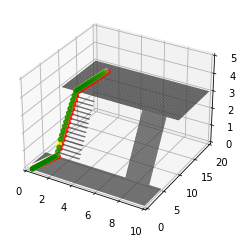

In [13]:
solutions = model.getAttr('x', footstepStates)
stepStrength = model.getAttr('x', footstepStrength)
    
optimalFootstepLF,optimalFootstepRF,optimalFootstepLH,optimalFootstepRH = getOptimalResults(solutions,N)

fig = plt.figure(2)
ax = fig.gca(projection='3d')
terrain.plotPlanes(ax,terrain.terrainPlanes)
ax.scatter(optimalFootstepLF[0,:],optimalFootstepLF[1,:],optimalFootstepLF[2,:],color = 'white')
ax.scatter(optimalFootstepRF[0,:],optimalFootstepRF[1,:],optimalFootstepRF[2,:],color = 'red')
ax.scatter(optimalFootstepLH[0,:],optimalFootstepLH[1,:],optimalFootstepLH[2,:],color = 'yellow')
ax.scatter(optimalFootstepRH[0,:],optimalFootstepRH[1,:],optimalFootstepRH[2,:],color = 'green')

ax.set_xlim([0,10])
ax.set_ylim([0,20])
ax.set_zlim([0,5])
plt.show()